# Импорты библиотек

In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from prettytable import PrettyTable
from scipy.stats import fisher_exact, mannwhitneyu
from scipy.stats.contingency import relative_risk
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

shap.initjs()

warnings.filterwarnings("ignore")

pd.set_option("display.float_format", "{:.2f}".format)

# Описание данных

**Описание задачи**

Отелям важно понимать, какое из бронирований может быть отменено пользователем. Возможные плюсы для отеля:

- **Оптимизация управления номерами**: Зная вероятность отмены бронирования заранее, отель может эффективнее управлять доступностью номеров. Например, можно предоставлять только часть номеров для онлайн-бронирований, чтобы минимизировать потери от отмены.
- **Планирование ресурсов**: Зная, что определенное количество бронирований скорее всего будет отменено, отель может более точно планировать свои ресурсы, включая персонал, инвентарь и питание.
- **Улучшение сервиса**: Предсказание отмены бронирования позволяет отелю своевременно связаться с гостем и предложить альтернативные варианты или скидки для удержания клиента. Это может помочь улучшить обслуживание и удовлетворенность клиентов.

**Задание**

Используя данные о бронированиях и отелях, требуется построить модель классификации, предсказывающую отмену бронирования.

| Название столбца | Данные в столбце |
| --- | --- |
| service\_id | Id бронирования |
| service\_date | Дата заказа бронирования |
| service\_checkin | Дата заезда в объект |
| service\_checkout | Дата выезда |
| service\_price | Стоимость бронирования |
| service\_child\_cnt | Количество детей в бронировании |
| service\_people\_cnt | Количество гостей (дети + взрослые) |
| client\_id | Id клиента |
| client\_segment | Сегмент клиента |
| hotel\_id | Id объекта |
| country\_name | Страна расположения объекта |
| city\_name | Город расположения объекта |
| category\_star | Количество звезд объекта (при наличии) |
| hotel\_type | Тип объекта |
| hotel\_seasonal | Флаг сезонности объекта |
| room\_category | Категория номера |
| service\_status | Последний статус бронирования: 0 - для выполненных заказов, 1 - для отмененных. |

# Константы

In [2]:
N_THREADS = -1
N_FOLDS = 5
RANDOM_STATE = 101
TEST_SIZE = 0.25
TARGET_NAME = "service_status"

# Загрузка данных

In [3]:
train = pd.read_csv("train.csv")
public_test = pd.read_csv("public_test.csv")
private_test = pd.read_csv("private_test.csv")

In [4]:
train.head()

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status
0,12528130,2016-12-28,2017-01-13,2017-01-20,78457.60,0.00,2.00,215314,b2bBusinessTravel,3538,Россия,NaN,5.00,hotel,0,70,0
1,12528139,2016-12-28,2017-01-16,2017-01-17,2395.80,0.00,1.00,210509,b2b2c,7695,Россия,Реутов,0.00,hotel,0,20,1
2,12528148,2016-12-28,2017-01-19,2017-01-23,10062.36,0.00,2.00,210509,b2b2c,36934,Россия,Санкт-Петербург,3.00,mini-hotel,0,50,0
3,12528157,2016-12-28,2016-12-31,2017-01-01,2332.00,0.00,2.00,213592,b2b2c,7107,Россия,Биробиджан,3.00,hotel,0,30,0
4,12528166,2016-12-28,2016-12-29,2016-12-30,2259.92,0.00,1.00,224181,b2bBusinessTravel,3966,Россия,Владивосток,0.00,hotel,0,30,0


In [5]:
public_test.head()

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category
0,31793052,2019-07-20,2019-07-21,2019-07-22,4473.87,0.00,2.00,291090,b2b2c,55696,Россия,Белоозерский,4.00,hotel,0,50
1,31793057,2019-07-20,2019-08-01,2019-08-02,8000.00,0.00,2.00,275640,b2b2c,303839,Россия,Артыбаш,4.00,mini-hotel,0,30
2,31793062,2019-07-20,2019-07-23,2019-07-24,3360.00,0.00,2.00,1183838,b2c,301189,Россия,Кемерово,3.00,hotel,0,40
3,31793067,2019-07-20,2019-07-20,2019-07-21,1596.87,0.00,2.00,291090,b2b2c,13935,Россия,Уфа,0.00,hostel,0,20
4,31793072,2019-07-20,2019-07-20,2019-07-21,3300.00,2.00,6.00,275640,b2b2c,135769,Россия,Пролетарск,2.00,mini-hotel,0,40


In [6]:
private_test.head()

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category
0,34987577,2019-11-20,2019-12-09,2019-12-11,6148.00,0.00,1.00,248088,b2bBusinessTravel,6732,Россия,Воронеж,4.00,hotel,0,30
1,34987582,2019-11-20,2019-11-23,2019-11-27,12545.00,0.00,1.00,293169,b2bBusinessTravel,10528,Россия,Нижний Новгород,3.00,hotel,0,50
2,34987587,2019-11-20,2020-01-08,2020-01-09,2531.00,0.00,1.00,1004251,b2b2c,3819,Россия,Минеральные Воды,3.00,hotel,0,30
3,34987592,2019-11-20,2019-12-06,2019-12-18,31130.40,0.00,1.00,215314,b2bBusinessTravel,2317,Россия,Арсеньев,3.00,hotel,0,30
4,34987597,2019-11-20,2019-11-23,2019-11-26,8056.11,0.00,1.00,291090,b2b2c,16538,Россия,Смоленск,4.00,hotel,0,40


# Поиск и обработка выбросов

## Столбцы с датами

Преобразуем данные в столбцах *service_date*, *service_checkin*, *service_checkout* к типу Timestamp

In [7]:
dataframes = [train, public_test, private_test]
columns_to_convert = ["service_date", "service_checkin", "service_checkout"]

for df in dataframes:
    df[columns_to_convert] = df[columns_to_convert].apply(pd.to_datetime)

Исправим ошибки: дата бронирования позже даты заезда.

In [8]:
for df in dataframes:
    df.loc[(df["service_date"] > df["service_checkin"]), "service_date"] = df[
        "service_checkin"
    ]

Добавим несколько новых признаков: *length_of_stay*, *days_until_checkin*

In [9]:
for df in dataframes:
    df["length_of_stay"] = (df["service_checkout"] - df["service_checkin"]).dt.days
    df.loc[df["length_of_stay"] == 0, "length_of_stay"] = 1
    df["days_until_checkin"] = (df["service_checkin"] - df["service_date"]).dt.days

## Столбец *service_price*

In [10]:
train["service_price"].describe()

count   2832810.00
mean       9568.75
std       13483.32
min         -90.00
25%        3230.00
50%        5725.00
75%       11138.00
max     1976845.50
Name: service_price, dtype: float64

In [11]:
public_test["service_price"].describe()

count    607030.00
mean      10243.83
std       15652.05
min           0.00
25%        3261.00
50%        5953.50
75%       12000.00
max     3321884.00
Name: service_price, dtype: float64

In [12]:
private_test["service_price"].describe()

count    607030.00
mean      11292.64
std       23102.03
min           0.00
25%        3392.00
50%        6307.00
75%       12800.56
max     6835200.00
Name: service_price, dtype: float64

Отрицательные и нулевые стоимости бронирования заменим на NaN

In [13]:
for df in dataframes:
    df.loc[df["service_price"] <= 0, "service_price"] = np.nan

Введем новый признак *price_per_day_one_person*, перед этим избавимся от строк с пропусками в *service_child_cnt* и *service_people_cnt*

In [14]:
train[["service_child_cnt", "service_people_cnt"]].isna().sum()

service_child_cnt     258
service_people_cnt    258
dtype: int64

In [15]:
public_test[["service_child_cnt", "service_people_cnt"]].isna().sum()

service_child_cnt     0
service_people_cnt    0
dtype: int64

In [16]:
private_test[["service_child_cnt", "service_people_cnt"]].isna().sum()

service_child_cnt     0
service_people_cnt    0
dtype: int64

In [17]:
train.loc[train["service_child_cnt"] > train["service_people_cnt"]]

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status,length_of_stay,days_until_checkin


In [18]:
train[train["service_child_cnt"].isna() | train["service_people_cnt"].isna()]

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status,length_of_stay,days_until_checkin
99266,13471664,2017-03-14,2017-03-19,2017-03-20,22680.90,NaN,NaN,263612,b2bBusinessTravel,6922,Россия,Новосибирск,5.00,hotel,0,30,1,1,5
475263,17079542,2017-10-03,2017-10-03,2017-10-04,2788.00,NaN,NaN,262343,b2bBusinessTravel,21621,Россия,Павловск,0.00,mini-hotel,0,30,1,1,0
492477,17247563,2017-09-28,2017-09-28,2017-10-01,16330.00,NaN,NaN,210179,b2bBusinessTravel,802,Россия,Якутск,4.00,hotel,0,30,0,3,0
498923,17310374,2017-10-15,2017-10-15,2017-10-18,7226.70,NaN,NaN,215314,b2bBusinessTravel,68037,Россия,Михайловка,0.00,mini-hotel,0,30,0,3,0
500107,17321813,2017-10-15,2017-10-15,2017-10-16,5720.00,NaN,NaN,206250,b2bTravelAgencies,1087,Россия,Челябинск,4.00,hotel,0,80,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635010,18615041,2017-12-23,2017-12-23,2017-12-24,2188.00,NaN,NaN,281987,b2g,17487,Россия,Липецк,3.00,hotel,0,30,0,1,0
635026,18615194,2017-12-24,2017-12-24,2017-12-24,3850.00,NaN,NaN,281987,b2g,45769,Россия,Фрязино,4.00,hotel,0,30,0,1,0
635027,18615203,2017-12-24,2017-12-24,2017-12-24,3850.00,NaN,NaN,281987,b2g,45769,Россия,Фрязино,4.00,hotel,0,30,0,1,0
635028,18615212,2017-12-24,2017-12-24,2017-12-24,3850.00,NaN,NaN,281987,b2g,45769,Россия,Фрязино,4.00,hotel,0,30,0,1,0


In [19]:
train[train["service_child_cnt"].isna() | train["service_people_cnt"].isna()].shape[
    0
] / train.shape[0] * 100

0.009107564573691846

Так как доля бронирований с пропусками в признаках *service_child_cnt*, *service_people_cnt* составляет около 0.01 % от общего числа бронирований, мы можем удалить данные бронирования

In [20]:
train.dropna(subset=["service_child_cnt", "service_people_cnt"], inplace=True)

In [21]:
train["service_people_cnt"].describe()

count   2832552.00
mean          1.81
std           1.08
min           1.00
25%           1.00
50%           2.00
75%           2.00
max          16.00
Name: service_people_cnt, dtype: float64

In [22]:
public_test["service_people_cnt"].describe()

count   607030.00
mean         1.52
std          0.92
min          1.00
25%          1.00
50%          1.00
75%          2.00
max         16.00
Name: service_people_cnt, dtype: float64

In [23]:
private_test["service_people_cnt"].describe()

count   607030.00
mean         1.29
std          0.57
min          1.00
25%          1.00
50%          1.00
75%          1.00
max         11.00
Name: service_people_cnt, dtype: float64

Введем новый признак *price_per_day_one_person*

In [24]:
for df in dataframes:
    df["price_per_day_one_person"] = np.round(
        (df["service_price"] / df["length_of_stay"]) / df["service_people_cnt"]
    )

In [25]:
train["price_per_day_one_person"].describe()

count   2832208.00
mean       2853.45
std        2481.64
min           0.00
25%        1402.00
50%        2317.00
75%        3606.00
max      368728.00
Name: price_per_day_one_person, dtype: float64

In [26]:
train.sort_values(by="price_per_day_one_person", ascending=False).head()

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status,length_of_stay,days_until_checkin,price_per_day_one_person
1072186,22594606,2018-06-03,2018-07-15,2018-07-17,737455.00,0.00,1.00,257133,b2bBusinessTravel,6439,Россия,"Дулепово, деревня",4.00,hotel,0,80,0,2,42,368728.00
792043,20106059,2018-03-18,2018-06-11,2018-06-13,658800.00,0.00,1.00,209510,b2bBusinessTravel,479,Россия,Санкт-Петербург,5.00,hotel,0,40,0,2,85,329400.00
792040,20106032,2018-03-18,2018-06-11,2018-06-13,592920.00,0.00,1.00,209510,b2bBusinessTravel,479,Россия,Санкт-Петербург,5.00,hotel,0,30,0,2,85,296460.00
1393155,24271200,2018-08-15,2018-08-18,2018-08-25,1976845.50,0.00,1.00,211512,b2bBusinessTravel,8510,Россия,Красная Поляна,4.00,hotel,0,30,0,7,3,282406.00
1038583,22419391,2018-05-26,2018-06-12,2018-06-14,537800.00,0.00,1.00,205358,b2bBusinessTravel,5024,Россия,Санкт-Петербург,5.00,hotel,0,40,0,2,17,268900.00


Реализуем функцию для поиска границ допустимых значений (не выбросов).

In [27]:
def search_outliers(feature):
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    iqr = q3 - q1
    lower_bound = 0
    upper_bound = q3 + 2 * iqr  # Завысим границу допустимых значений из-за того,
    # что цена может существенно зависеть от города и от категории номера
    return upper_bound

In [28]:
train_price_outliers_limits = train.groupby("category_star")[
    "price_per_day_one_person"
].apply(search_outliers)

print(train_price_outliers_limits)

category_star
0.00    5564.00
1.00    5158.00
2.00    5521.00
3.00    6949.00
4.00   10150.00
5.00   17578.00
Name: price_per_day_one_person, dtype: float64


In [29]:
train["category_star"].isna().sum()

1

In [30]:
public_test["category_star"].isna().sum()

1

In [31]:
for df in dataframes:
    df.loc[df["category_star"].isna(), "category_star"] = 0

Релизуем функцию изменения значения выбросов на NaN

In [32]:
def replace_outliers_with_nan(row):
    category = row["category_star"]
    price = row["price_per_day_one_person"]
    if price > train_price_outliers_limits[category]:
        return np.nan
    else:
        return price

Выбросы в признаке *price_per_day_one_person* заменим на NaN

In [33]:
for df in dataframes:
    df["price_per_day_one_person"] = df.apply(replace_outliers_with_nan, axis=1)
    df.loc[df["price_per_day_one_person"].isna(), "service_price"] = np.nan

## Столбцы *city_name*, *country_name*

In [34]:
train["country_name"].value_counts()

country_name
Россия          2744443
Беларусь          54329
Казахстан         13047
Узбекистан         7918
Абхазия            4357
Кыргызстан         3577
Армения            2848
Таджикистан         723
Украина             597
Южная Осетия        269
Грузия              235
Азербайджан         169
Египет               25
Молдавия              8
Туркменистан          6
Эстония               1
Name: count, dtype: int64

В признаке *country_name* заменим все страны кроме России на 'Зарубежная страна'

In [35]:
for df in dataframes:
    df.loc[df["country_name"] != "Россия", "country_name"] = "Зарубежная страна"

Определим часто встречаемые города (с числом бронирований больше 40000), города, которые не входят в данный список заменим на 'Редкий город'

In [36]:
pop_cities_values = train["city_name"].value_counts() > 40000
pop_cities = pop_cities_values[pop_cities_values].index

for df in dataframes:
    df["city_name"] = df["city_name"].map(
        lambda x: "Редкий город" if x not in pop_cities else x
    )

# Заполнение пропусков

In [37]:
train.isna().sum()

service_id                      0
service_date                    0
service_checkin                 0
service_checkout                0
service_price               55752
service_child_cnt               0
service_people_cnt              0
client_id                       0
client_segment              29730
hotel_id                        0
country_name                    0
city_name                       0
category_star                   0
hotel_type                      0
hotel_seasonal                  0
room_category                   0
service_status                  0
length_of_stay                  0
days_until_checkin              0
price_per_day_one_person    55752
dtype: int64

In [38]:
public_test.isna().sum()

service_id                      0
service_date                    0
service_checkin                 0
service_checkout                0
service_price               27993
service_child_cnt               0
service_people_cnt              0
client_id                       0
client_segment               2168
hotel_id                        0
country_name                    0
city_name                       0
category_star                   0
hotel_type                      0
hotel_seasonal                  0
room_category                   0
length_of_stay                  0
days_until_checkin              0
price_per_day_one_person    27993
dtype: int64

In [39]:
private_test.isna().sum()

service_id                      0
service_date                    0
service_checkin                 0
service_checkout                0
service_price               34764
service_child_cnt               0
service_people_cnt              0
client_id                       0
client_segment                191
hotel_id                        0
country_name                    0
city_name                       0
category_star                   0
hotel_type                      0
hotel_seasonal                  0
room_category                   0
length_of_stay                  0
days_until_checkin              0
price_per_day_one_person    34764
dtype: int64

In [40]:
# Функция для заполнения NaN медианой группы
def fill_na_with_median(train_df, test_df, test_df_private, group_col, fill_col):
    # Заполнение пропусков в обучающем наборе
    train_df[fill_col] = train_df.groupby(group_col)[fill_col].transform(
        lambda x: x.fillna(x.median())
    )

    # Рассчитываем медиану для каждой группы на обучающем наборе
    modes = train_df.groupby(group_col)[fill_col].agg(lambda x: x.median()).to_dict()

    # Применяем медины для заполнения пропусков в тестовом наборе
    test_df[fill_col] = test_df.apply(
        lambda row: (
            row[fill_col]
            if pd.notna(row[fill_col])
            else modes.get(row[group_col], np.nan)
        ),
        axis=1,
    )

    test_df_private[fill_col] = test_df_private.apply(
        lambda row: (
            row[fill_col]
            if pd.notna(row[fill_col])
            else modes.get(row[group_col], np.nan)
        ),
        axis=1,
    )

    return train_df, test_df, test_df_private

In [41]:
# Функция для заполнения NaN модой группы
def fill_na_with_mode(train_df, test_df, test_df_private, group_col, fill_col):
    # Заполнение пропусков в обучающем наборе
    train_df[fill_col] = train_df.groupby(group_col)[fill_col].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
    )

    # Рассчитываем моду для каждой группы на обучающем наборе
    modes = (
        train_df.groupby(group_col)[fill_col]
        .agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
        .to_dict()
    )

    # Применяем моду для заполнения пропусков в тестовом наборе
    test_df[fill_col] = test_df.apply(
        lambda row: (
            row[fill_col]
            if pd.notna(row[fill_col])
            else modes.get(row[group_col], np.nan)
        ),
        axis=1,
    )

    test_df_private[fill_col] = test_df_private.apply(
        lambda row: (
            row[fill_col]
            if pd.notna(row[fill_col])
            else modes.get(row[group_col], np.nan)
        ),
        axis=1,
    )

    return train_df, test_df, test_df_private

Заполним пропуски в признаках *price_per_day_one_person* и *service_price*

In [42]:
for df in dataframes:
    df["service_price"] = df["service_price"].fillna(
        df["price_per_day_one_person"] * df["service_people_cnt"] * df["length_of_stay"]
    )

In [43]:
train, public_test, private_test = fill_na_with_median(
    train, public_test, private_test, "category_star", "price_per_day_one_person"
)

In [44]:
for df in dataframes:
    df["service_price"] = df["service_price"].fillna(
        df["price_per_day_one_person"] * df["service_people_cnt"] * df["length_of_stay"]
    )

Заполним пропуски в признаке *client_segment*

In [45]:
train, public_test, private_test = fill_na_with_mode(
    train, public_test, private_test, "client_id", "client_segment"
)

In [46]:
print(train["client_segment"].isnull().sum())
print(public_test["client_segment"].isnull().sum())
print(private_test["client_segment"].isnull().sum())

29730
2168
191


In [47]:
train, public_test, private_test = fill_na_with_mode(
    train, public_test, private_test, "hotel_type", "client_segment"
)

In [48]:
train.isna().sum()

service_id                  0
service_date                0
service_checkin             0
service_checkout            0
service_price               0
service_child_cnt           0
service_people_cnt          0
client_id                   0
client_segment              0
hotel_id                    0
country_name                0
city_name                   0
category_star               0
hotel_type                  0
hotel_seasonal              0
room_category               0
service_status              0
length_of_stay              0
days_until_checkin          0
price_per_day_one_person    0
dtype: int64

In [49]:
public_test.isna().sum()

service_id                  0
service_date                0
service_checkin             0
service_checkout            0
service_price               0
service_child_cnt           0
service_people_cnt          0
client_id                   0
client_segment              0
hotel_id                    0
country_name                0
city_name                   0
category_star               0
hotel_type                  0
hotel_seasonal              0
room_category               0
length_of_stay              0
days_until_checkin          0
price_per_day_one_person    0
dtype: int64

In [50]:
private_test.isna().sum()

service_id                  0
service_date                0
service_checkin             0
service_checkout            0
service_price               0
service_child_cnt           0
service_people_cnt          0
client_id                   0
client_segment              0
hotel_id                    0
country_name                0
city_name                   0
category_star               0
hotel_type                  0
hotel_seasonal              0
room_category               0
length_of_stay              0
days_until_checkin          0
price_per_day_one_person    0
dtype: int64

In [51]:
train.head()

,service_id,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status,length_of_stay,days_until_checkin,price_per_day_one_person
0,12528130,2016-12-28,2017-01-13,2017-01-20,78457.60,0.00,2.00,215314,b2bBusinessTravel,3538,Россия,Редкий город,5.00,hotel,0,70,0,7,16,5604.00
1,12528139,2016-12-28,2017-01-16,2017-01-17,2395.80,0.00,1.00,210509,b2b2c,7695,Россия,Редкий город,0.00,hotel,0,20,1,1,19,2396.00
2,12528148,2016-12-28,2017-01-19,2017-01-23,10062.36,0.00,2.00,210509,b2b2c,36934,Россия,Санкт-Петербург,3.00,mini-hotel,0,50,0,4,22,1258.00
3,12528157,2016-12-28,2016-12-31,2017-01-01,2332.00,0.00,2.00,213592,b2b2c,7107,Россия,Редкий город,3.00,hotel,0,30,0,1,3,1166.00
4,12528166,2016-12-28,2016-12-29,2016-12-30,2259.92,0.00,1.00,224181,b2bBusinessTravel,3966,Россия,Редкий город,0.00,hotel,0,30,0,1,1,2260.00


Избавимся от признаков, которые интуитивно уже не являются значимыми на данном этапе.

In [52]:
for df in dataframes:
    df.drop(
        columns=[
            "service_id",
            "service_date",
            "service_checkin",
            "service_checkout",
            "client_id",
            "hotel_id",
        ],
        inplace=True,
    )

In [53]:
train.head()

,service_price,service_child_cnt,service_people_cnt,client_segment,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status,length_of_stay,days_until_checkin,price_per_day_one_person
0,78457.60,0.00,2.00,b2bBusinessTravel,Россия,Редкий город,5.00,hotel,0,70,0,7,16,5604.00
1,2395.80,0.00,1.00,b2b2c,Россия,Редкий город,0.00,hotel,0,20,1,1,19,2396.00
2,10062.36,0.00,2.00,b2b2c,Россия,Санкт-Петербург,3.00,mini-hotel,0,50,0,4,22,1258.00
3,2332.00,0.00,2.00,b2b2c,Россия,Редкий город,3.00,hotel,0,30,0,1,3,1166.00
4,2259.92,0.00,1.00,b2bBusinessTravel,Россия,Редкий город,0.00,hotel,0,30,0,1,1,2260.00


In [54]:
for df in dataframes:
    df[["category_star", "hotel_seasonal", "room_category"]] = df[
        ["category_star", "hotel_seasonal", "room_category"]
    ].astype(object)

In [55]:
num_features = (
    train.drop(columns=TARGET_NAME).select_dtypes(exclude=object).columns.to_list()
)
cat_features = (
    train.drop(columns=TARGET_NAME).select_dtypes(include=object).columns.to_list()
)

In [56]:
train[TARGET_NAME] = train[TARGET_NAME].astype(str)

# EDA

Посмотрим на соотношение классов целевой переменной

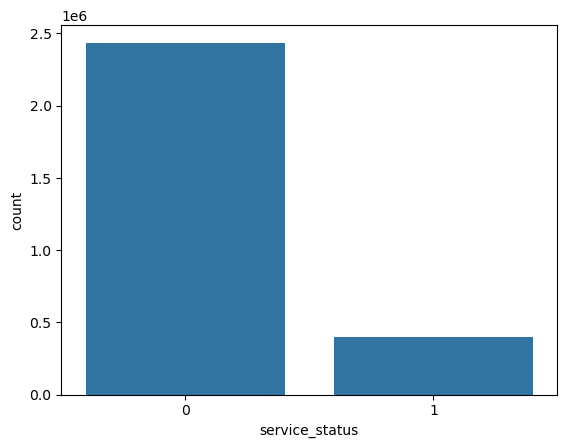

In [57]:
sns.countplot(data=train, x=TARGET_NAME);

Мы убедились, что значения целевой переменной несбалансированы, преобладает класс клиентов, которые не отменяют бронирование.

## Список гипотез

Далее сформулируем гипотезы:

1) Наличие детей не влияет на отмену бронирования;  
2) Клиентский сегмент не влияет на отмену бронирования;  
3) Стоимость проживания на одного человека за сутки не влияет на отмену бронирования;
4) Количество дней до заезда не влияет на отмену брониварония.

## Проверка гипотезы 1

Для проверки первой гипотезы сформируем новый столбцец в нашем датафрейме, который будет содержать значение 1 если клиент заезжает с детьми и 0 если нет.

In [58]:
train["has_children"] = (
    train["service_child_cnt"].apply(lambda x: 1 if x > 0 else 0).astype(object)
)

Text(0, 0.5, 'Доля отмененных бронирований')

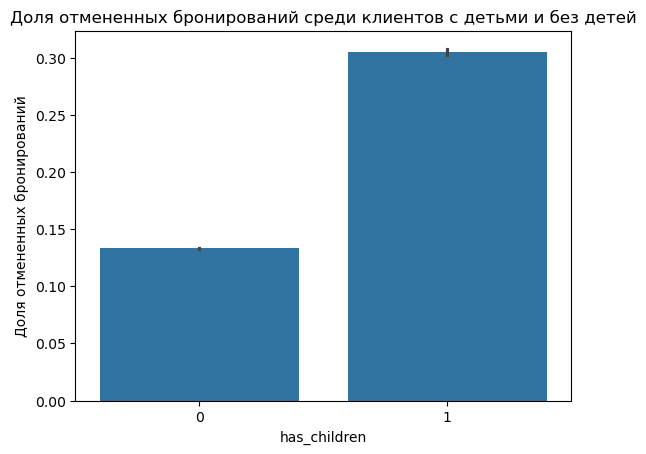

In [59]:
train[TARGET_NAME] = train[TARGET_NAME].astype(int)

sns.barplot(data=train, x="has_children", y=TARGET_NAME).set_title(
    "Доля отмененных бронирований среди клиентов с детьми и без детей"
)
plt.ylabel("Доля отмененных бронирований")

Представленный выше график демонстирует, что среди клиентов с детьми доля отмен бронирования выше, чем среди клиентов без детей.

Дополнительно убедимся в этом используя точный тест Фишера и расчет относительного риска

In [60]:
train["has_children"] = train["has_children"].astype(int)
train[TARGET_NAME] = train[TARGET_NAME].astype(int)

In [61]:
# Оценка относительного риска и точный тест Фишера.
# На вход подаются названия колонок, содержащих фактор риска и исход.
def safeRiskCalc(numerator, denumerator):
    if denumerator != 0:
        return str(round(numerator / denumerator * 100, 2))
    else:
        return "---"


def riskEstimation(factorRisk, outcome):
    expRiskOutcomeYes = len(
        train[(train[factorRisk] == 1) & (train[outcome] == 1)].index
    )
    expRiskOutcomeNo = len(
        train[(train[factorRisk] == 1) & (train[outcome] == 0)].index
    )
    expRisk = expRiskOutcomeYes + expRiskOutcomeNo

    controlOutcomeYes = len(
        train[(train[factorRisk] == 0) & (train[outcome] == 1)].index
    )
    controlOutcomeNo = len(
        train[(train[factorRisk] == 0) & (train[outcome] == 0)].index
    )
    control = controlOutcomeYes + controlOutcomeNo

    pt = PrettyTable()

    cellYY = (
        str(expRiskOutcomeYes) + " (" + safeRiskCalc(expRiskOutcomeYes, expRisk) + " %)"
    )
    cellYN = (
        str(expRiskOutcomeNo) + " (" + safeRiskCalc(expRiskOutcomeNo, expRisk) + " %)"
    )
    cellNY = (
        str(controlOutcomeYes) + " (" + safeRiskCalc(controlOutcomeYes, control) + " %)"
    )
    cellNN = (
        str(controlOutcomeNo) + " (" + safeRiskCalc(controlOutcomeNo, control) + " %)"
    )

    pt.field_names = ["   ", outcome + " = Да", outcome + " = Нет", "Итого"]
    pt.add_row([factorRisk + " = Да", cellYY, cellYN, expRisk])
    pt.add_row([factorRisk + " = Нет", cellNY, cellNN, control])
    pt.add_row(
        [
            "Итого",
            expRiskOutcomeYes + controlOutcomeYes,
            expRiskOutcomeNo + controlOutcomeNo,
            expRisk + control,
        ]
    )
    print(pt)

    try:
        RR = relative_risk(
            expRiskOutcomeYes,
            expRiskOutcomeYes + expRiskOutcomeNo,
            controlOutcomeYes,
            controlOutcomeYes + controlOutcomeNo,
        )
        print("RR =", round(RR.relative_risk, 3))
        CIlow = round(RR.confidence_interval(confidence_level=0.95).low, 2)
        CIhigh = round(RR.confidence_interval(confidence_level=0.95).high, 2)
        print("CI = [", CIlow, "; ", CIhigh, "]", sep="")
    except:
        print("Невозможно найти RR")

    fisherTest = fisher_exact(
        [[expRiskOutcomeYes, expRiskOutcomeNo], [controlOutcomeYes, controlOutcomeNo]]
    )
    print(f"Точный тест Фишера p-value = {fisherTest[1]:e}")

In [62]:
riskEstimation("has_children", TARGET_NAME)

+--------------------+---------------------+----------------------+---------+
|                    | service_status = Да | service_status = Нет |  Итого  |
+--------------------+---------------------+----------------------+---------+
| has_children = Да  |   31294 (30.52 %)   |   71232 (69.48 %)    |  102526 |
| has_children = Нет |   364145 (13.34 %)  |  2365881 (86.66 %)   | 2730026 |
|       Итого        |        395439       |       2437113        | 2832552 |
+--------------------+---------------------+----------------------+---------+
RR = 2.288
CI = [2.27; 2.31]
Точный тест Фишера p-value = 0.000000e+00


Расчитанное значение относительного риска составляет 2.288 и доверительный интервал для данной оценки не включает 1, следовательно, можно сделать вывод, что клиенты с детьми чаще отменяют бронирования.  

Также в результате применения точного теста Фишера p-value принимает очень маленькое значение, которое существенно меньше уровня значимости 0.05, следовательно, нулевую гипотезу об отсутствии связи между наличием детей и отменой бронирования необходимо отвергнуть.

In [63]:
train.drop(columns="has_children", inplace=True)

## Проверка гипотезы 2

Проверим гипотезу 2: клиентский сегмент не влияет на отмену бронирования.

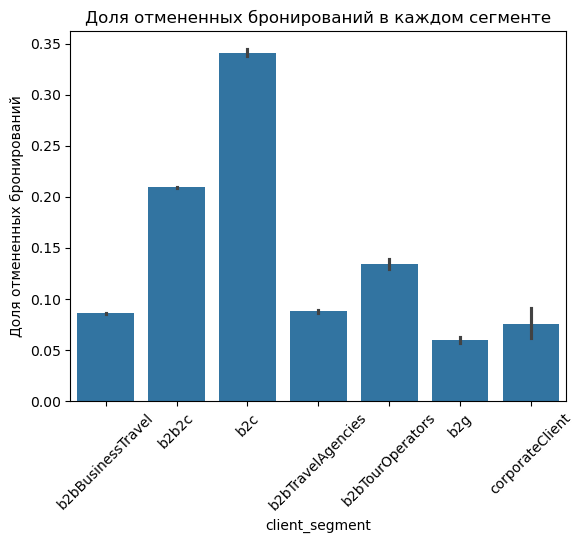

In [64]:
sns.barplot(data=train, x="client_segment", y=TARGET_NAME).set_title(
    "Доля отмененных бронирований в каждом сегменте"
)
plt.ylabel("Доля отмененных бронирований")
plt.xticks(rotation=45);

Гипотезу о том, что сегмент клиента не вляет на отмену бронирования необходимо отвергуть.  
Так как, например, в сегменте b2c доля отмен бронирований составляет около 35%, в то время как в сегменте b2g доля отмен весьма мала (около 7%).

## Проверка гипотезы 3

Проверим гипотезу 3: сезонность отеля не влияет на отмену бронирования.  
Воспользуемся точным тестом Фишера.

In [65]:
train["hotel_seasonal"] = train["hotel_seasonal"].astype(int)
train[TARGET_NAME] = train[TARGET_NAME].astype(int)

In [66]:
riskEstimation("hotel_seasonal", TARGET_NAME)

+----------------------+---------------------+----------------------+---------+
|                      | service_status = Да | service_status = Нет |  Итого  |
+----------------------+---------------------+----------------------+---------+
| hotel_seasonal = Да  |    7160 (28.83 %)   |   17675 (71.17 %)    |  24835  |
| hotel_seasonal = Нет |   388279 (13.83 %)  |  2419438 (86.17 %)   | 2807717 |
|        Итого         |        395439       |       2437113        | 2832552 |
+----------------------+---------------------+----------------------+---------+
RR = 2.085
CI = [2.04; 2.13]
Точный тест Фишера p-value = 0.000000e+00


Так как p-value < 0.05, мы отвергаем нулевую гипотезу о том, что сезонность отеля не вляет на отмену бронирования.  
Также наличие связи между сезонностью отеля и отменой бронирования подтверждает значение  
оценки относительного риска 2.085 и ее доверительный интервал, который не включает 1.  
То есть в сезонных отелях клиенты чаще отменяют бронирования.

## Проверка гипотезы 4

Проверим, значимо ли отличаются генеральные средние количества дней до заезда у отмененных бронирований и у неотмененных.

Посмотрим на распределение признака.

(-10.0, 100.0)

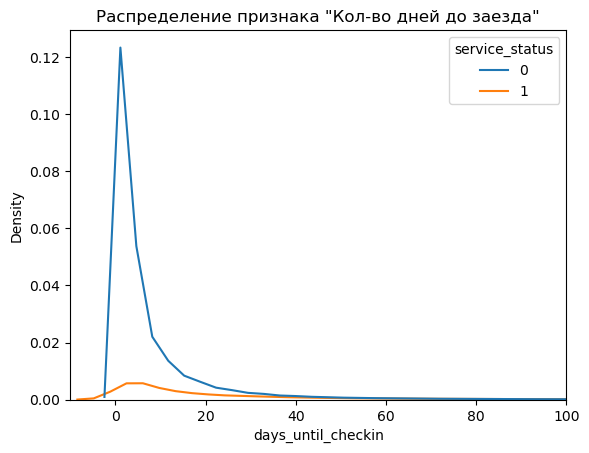

In [72]:
sns.kdeplot(data=train, x='days_until_checkin', hue=TARGET_NAME).set_title('Распределение признака "Кол-во дней до заезда"')
plt.xlim(-10,100)

Видим, что распределение существенно отличается от нормального, для сравнения средних воспользуемся непараметрическим критерием Манна-Уитни.

In [ ]:
days_until_checkin_neg = train.loc[train['service_status'] == 0, 'days_until_checkin']
days_until_checkin_pos = train.loc[train['service_status'] == 1, 'days_until_checkin']

stat, p = mannwhitneyu(days_until_checkin_neg, days_until_checkin_pos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p >= alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=248689848925.000, p=0.000
Different distribution (reject H0)


In [74]:
days_until_checkin_neg.mean()

7.831672967154169

In [75]:
days_until_checkin_pos.mean()

25.362240446693423

Так значение p-value много меньше уровня значимости 0.05, то нулевую гипотезу от том,  
что генеральные средние количества дней до заезда у отменненных и у неотмененных бронирований равны, отвергаем.

То есть количество дней до заезда влияет на отмену бронирования.

# Приведение категориальных признаков к типу object

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2832552 entries, 0 to 2832809
Data columns (total 14 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   service_price             float64
 1   service_child_cnt         float64
 2   service_people_cnt        float64
 3   client_segment            object 
 4   country_name              object 
 5   city_name                 object 
 6   category_star             object 
 7   hotel_type                object 
 8   hotel_seasonal            int32  
 9   room_category             object 
 10  service_status            int32  
 11  length_of_stay            int64  
 12  days_until_checkin        int64  
 13  price_per_day_one_person  float64
dtypes: float64(4), int32(2), int64(2), object(6)
memory usage: 302.5+ MB


In [70]:
for df in dataframes:
    df["hotel_seasonal"] = df["hotel_seasonal"].astype(object)

In [71]:
cat_features

['client_segment',
 'country_name',
 'city_name',
 'category_star',
 'hotel_type',
 'hotel_seasonal',
 'room_category']

# Обучение модели XGBClassifier

In [72]:
for df in dataframes:
    df[cat_features] = df[cat_features].astype("category")

In [73]:
X = train.drop(columns=[TARGET_NAME])
y = train[TARGET_NAME]

In [74]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [76]:
model = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    objective="binary:logistic",
    enable_categorical=True,
    early_stopping_rounds=50,
    n_estimators=500,
)

In [ ]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True);

In [78]:
print("Лучшая Итерация: {}".format(model.get_booster().best_iteration))

Лучшая Итерация: 459


In [79]:
results = model.evals_result()

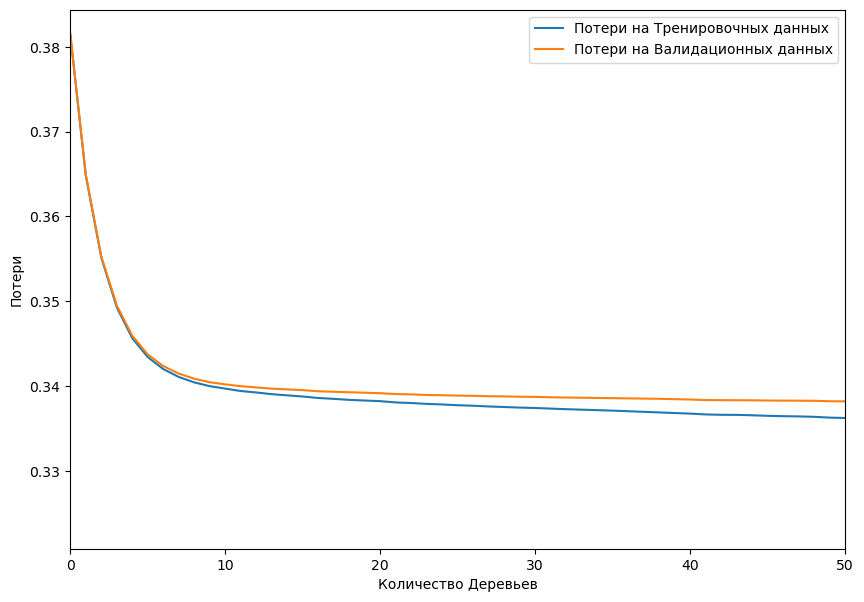

In [80]:
plt.figure(figsize=(10, 7))
plt.plot(results["validation_0"]["logloss"], label="Потери на Тренировочных данных")
plt.plot(results["validation_1"]["logloss"], label="Потери на Валидационных данных")
plt.xlabel("Количество Деревьев")
plt.ylabel("Потери")
plt.xlim(0, 50)
plt.legend();

График выше демонстрирует, что начиная с 10, количество деревьев не приводит к существенному уменьшению функции потерь.

In [83]:
def calculate_metric(model_pipe, X, y, metric=f1_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model, average="macro")

In [82]:
print(
    f"f1_macro на тренировочной выборке: {calculate_metric(model, X_train, y_train):.4f}"
)
print(f"f1_macro на валидационной выборке: {calculate_metric(model, X_val, y_val):.4f}")

f1_macro на тренировочной выборке: 0.5884
f1_macro на валидационной выборке: 0.5688


## Настройка гиперпараметров

Для поиска оптимальных гиперпараметров воспользуемся Optuna.

In [83]:
def objective_xgb(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 10, 30),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.01, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0, log=True),
        "colsample_bytree": trial.suggest_float(
            "colsample_bytree", 0.01, 1.0, log=True
        ),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 3),
        "class_weight": "balanced",
        "random_state": RANDOM_STATE,
        "enable_categorical": True,
        "objective": "binary:logistic",
    }

    estimator = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    score = cross_val_score(
        estimator, X_train_val, y_train_val, scoring="f1_macro", cv=cv, n_jobs=N_THREADS
    )

    final_score = score.mean()

    return final_score

In [ ]:
study_XGB = optuna.create_study(
    direction="maximize",
    study_name="study_XGB",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.HyperbandPruner(),
)
study_XGB.optimize(objective_xgb, n_trials=20, n_jobs=N_THREADS)

In [86]:
study_XGB.best_value

0.6587989549110663

In [87]:
best_params_xgb = study_XGB.best_params
best_params_xgb

{'max_depth': 6,
 'learning_rate': 0.26357943923561694,
 'n_estimators': 24,
 'min_child_weight': 8,
 'gamma': 0.8024746843298376,
 'subsample': 0.07868732449205428,
 'colsample_bytree': 0.24996487930837125,
 'scale_pos_weight': 3}

In [89]:
xgb_model_best = xgb.XGBClassifier(
    **best_params_xgb,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    enable_categorical=True,
    objective="binary:logistic"
)
xgb_model_best

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.24996487930837125,
              device=None, early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0.8024746843298376,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.26357943923561694,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=24, n_jobs=None,
              num_parallel_tree=None, ...)

# Обучение модели LogisticRegression

Кодирование категориальных признаков.

In [78]:
transformer = ColumnTransformer(
    [
        (
            "cat_prep",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            cat_features,
        ),
        ("num_prep", StandardScaler(), num_features),
    ]
)

X_train_val_prep = transformer.fit_transform(X_train_val)
X_test_prep = transformer.transform(X_test)

X_train_val_prep_df = pd.DataFrame(
    X_train_val_prep,
    columns=cat_features + num_features,
)

X_test_prep_df = pd.DataFrame(X_test_prep, columns=cat_features + num_features)

In [79]:
X_train_prep, X_val_prep, y_train, y_val = train_test_split(
    X_train_val_prep_df,
    y_train_val,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_train_val,
)

Обучение модели со стандартными параметрами.

In [93]:
log_reg_model = LogisticRegression(random_state=RANDOM_STATE)

log_reg_model.fit(X_train_prep, y_train)

print(
    f"f1_macro на валидационной выборке: {calculate_metric(log_reg_model, X_val_prep, y_val):.4f}"
)

f1_macro на валидационной выборке: 0.5386


Поиск гиперпараметров:

In [96]:
def objective_log_reg(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l2", None]),
        "C": trial.suggest_float("C", 0.1, 1, log=True),
        "class_weight": "balanced",
        "n_jobs": N_THREADS,
        "random_state": RANDOM_STATE,
    }

    estimator = LogisticRegression(**params)

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    score = cross_val_score(
        estimator,
        X_train_val_prep_df,
        y_train_val,
        scoring="f1_macro",
        cv=cv,
        n_jobs=N_THREADS,
    )

    final_score = score.mean()

    return final_score

In [ ]:
study_log_reg = optuna.create_study(
    direction="maximize",
    study_name="study_log_reg",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.HyperbandPruner(),
)
study_log_reg.optimize(objective_log_reg, n_trials=20, n_jobs=N_THREADS)

In [98]:
best_params_log_reg = study_log_reg.best_params
best_params_log_reg

{'penalty': 'l2', 'C': 0.14244587914435233}

In [100]:
log_reg_model_best = LogisticRegression(
    **best_params_log_reg,
    class_weight="balanced",
    n_jobs=N_THREADS,
    random_state=RANDOM_STATE
)

# Анализ предсказаний обученных моделей

In [84]:
xgb_model_best.fit(X_train_val, y_train_val)
log_reg_model_best.fit(X_train_val_prep_df, y_train_val)

pred_xgb = xgb_model_best.predict(X_test)
pred_log_reg = log_reg_model_best.predict(X_test_prep_df)

In [85]:
print(
    f"f1_macro на тестовой выборке XGBClassifier: {calculate_metric(xgb_model_best, X_test, y_test):.4f}"
)
print(
    f"f1_macro на тестовой выборке LogisticRegression: {calculate_metric(log_reg_model_best, X_test_prep_df, y_test):.4f}"
)

f1_macro на тестовой выборке XGBClassifier: 0.6588
f1_macro на тестовой выборке LogisticRegression: 0.6293


Посмотрим на матрицы ошибок.

In [86]:
target_names = ["Без отмены", "Отмена"]

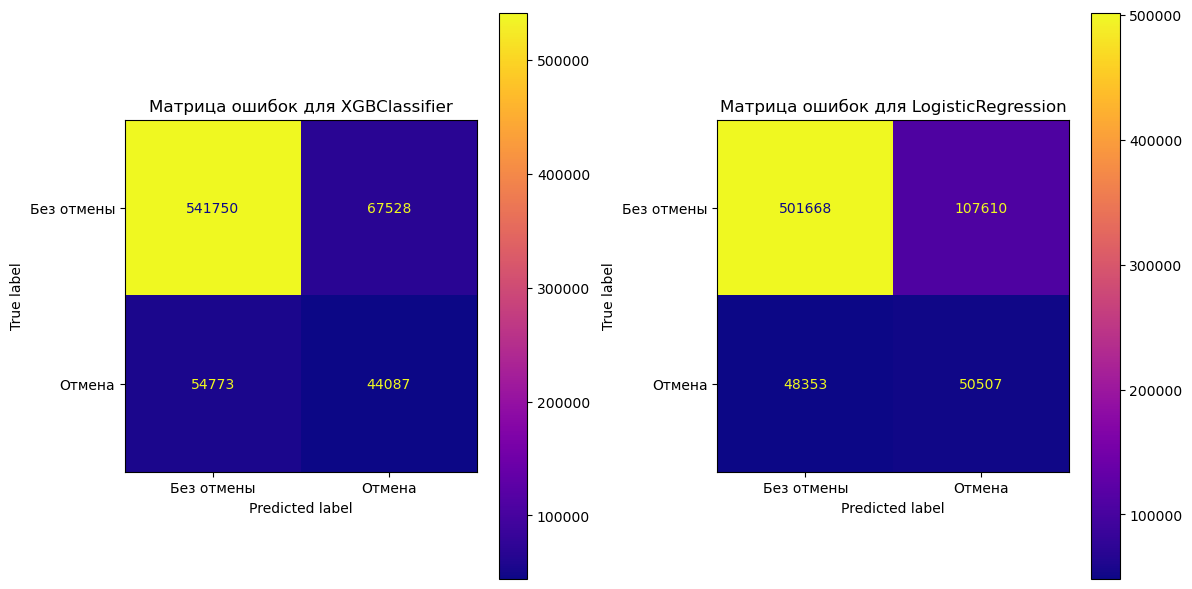

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay.from_predictions(
    y_test, pred_xgb, display_labels=target_names, cmap="plasma", ax=axs[0]
)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    pred_log_reg,
    display_labels=target_names,
    cmap="plasma",
    values_format=".0f",
    ax=axs[1],
)
axs[0].set_title("Матрица ошибок для XGBClassifier")
axs[1].set_title("Матрица ошибок для LogisticRegression")
plt.tight_layout()

Матрицы ошибок демонстрируют, что логистическая регрессия ошибочно классифицирует  
большее число объектов нулевого класса как положительный класс.  
  
При этом градиентный бустинг ошибочно классифицирует большее число объектов положительного класса как нулевой класс.

In [ ]:
target_names = ["Без отмены", "Отмена"]

print("Отчет с метриками для XGBClassifier")
print(classification_report(y_test, pred_xgb, target_names=target_names))

print("Отчет с метриками для LogisticRegression")
print(classification_report(y_test, pred_log_reg, target_names=target_names))

Отчет с метриками для XGBClassifier
              precision    recall  f1-score   support

  Без отмены       0.91      0.89      0.90    609278
      Отмена       0.39      0.45      0.42     98860

    accuracy                           0.83    708138
   macro avg       0.65      0.67      0.66    708138
weighted avg       0.84      0.83      0.83    708138

Отчет с метриками для LogisticRegression
              precision    recall  f1-score   support

  Без отмены       0.91      0.82      0.87    609278
      Отмена       0.32      0.51      0.39     98860

    accuracy                           0.78    708138
   macro avg       0.62      0.67      0.63    708138
weighted avg       0.83      0.78      0.80    708138



Из отчета с метриками видим, что модель логистической регрессии  
правильно классифицирует большую долю объектов положительного класса как положительный.  
При этом она более склонна ошибаться и предсказывать отмену для клиентов отелей, которые не отменяют бронирование.

Ошибочные предсказания XGBClassifier

In [89]:
mistakes_number_xgb = X_test.loc[(y_test != pred_xgb)].shape[0]
mistakes_number_xgb

122301

Ошибочные предсказания логистической регрессии

In [90]:
mistakes_number_logreg = X_test.loc[(y_test != pred_log_reg)].shape[0]
mistakes_number_logreg

155963

Ошибочные предсказания XGBClassifier, на которых логистическая регрессия тоже ошиблась.

In [91]:
mistakes_number_xgb_and_logreg = X_test.loc[
    (y_test != pred_xgb) & (y_test != pred_log_reg)
].shape[0]
mistakes_number_xgb_and_logreg

103591

Доля от ошибок XGBClassifier, на которых ошиблась логистическая регрессия

In [92]:
mistakes_number_xgb_and_logreg / mistakes_number_xgb

0.8470167864530952

Доля от ошибок логистической регрессии, на которых ошибался XGBClassifier

In [93]:
mistakes_number_xgb_and_logreg / mistakes_number_logreg

0.664202406981143

Процент ошибок XGBClassifier, на которых логистическая регрессия тоже ошибается, составляет около 85 %.  
Процент ошибок логистической регрессии, на которых XGBClassifier тоже ошибается, составляет около 66 %.

В целом, можно сказать, что модели ошибаются на одник и тех же объектах.  
Но так как у логистической регрессии качество предсказаний хуже, она дополнительно ошибается и на других объектах.

# Оценка глобальной значимости признаков (*sklearn*)

## Permutation importance и Partial dependence

Оценим важность предикторов методами *permutation importance* и *partial dependence*.

In [95]:
perm_importance_logreg = permutation_importance(
    log_reg_model_best,
    X_test_prep_df,
    y_test,
    scoring="f1_macro",
    n_repeats=5,
    random_state=RANDOM_STATE,
)


perm_importance_xgb = permutation_importance(
    xgb_model_best,
    X_test,
    y_test,
    scoring="f1_macro",
    n_repeats=5,
    random_state=RANDOM_STATE,
)

In [96]:
def permutation_importance_plotter(perm_importance, cols, axs=None):
    sorted_idx = perm_importance.importances_mean.argsort()
    if axs is None:
        fig, axs = plt.subplots(figsize=(12, 5))
    axs.barh(
        range(len(sorted_idx)),
        perm_importance.importances_mean[sorted_idx],
        align="center",
    )
    axs.set_yticks(range(len(sorted_idx)), cols[sorted_idx])

Text(0.5, 1.0, 'permutation importance logreg')

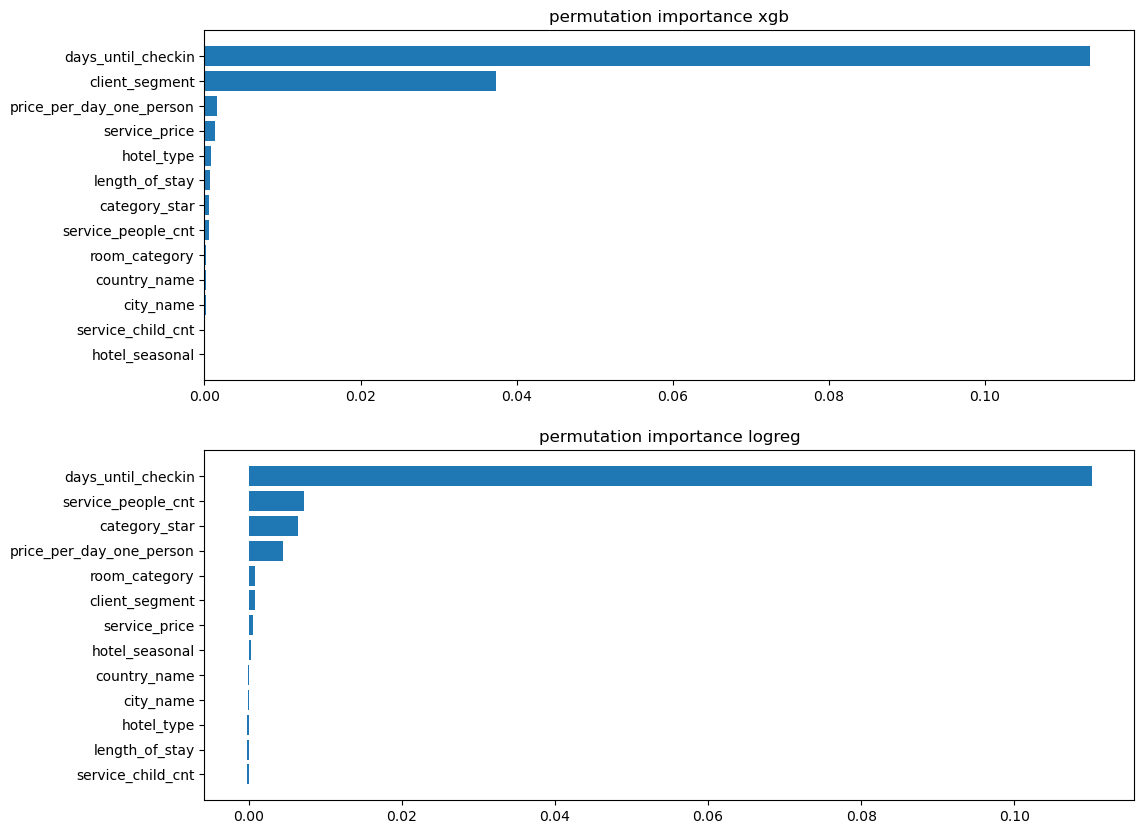

In [97]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
permutation_importance_plotter(
    perm_importance_xgb, np.array(X_test.columns), axs=axs[0]
)
permutation_importance_plotter(
    perm_importance_logreg, np.array(X_test_prep_df.columns), axs=axs[1]
)
axs[0].set_title("permutation importance xgb")
axs[1].set_title("permutation importance logreg")

По результатам *permutation importance* видим, что для обоих моделей оказывается важным количество дней до заезда.  
  
Далее идут расхождения...  
  
Для бустинга оказывается достаточно важным клиентский сегмент,  
в то время как логистическая регрессия слабо, но учитывает цену за сутки за 1 человека, число звезд и число проживающих.

Важность остальных признаков для моделей весьма мала.  
  
Ранее мы уже рассматривали признак *клиентский сегмент* и *количество дней до заезда*, тогда они показались нам важными, получается, что мы не ошиблись.

Построим *partial dependence*.

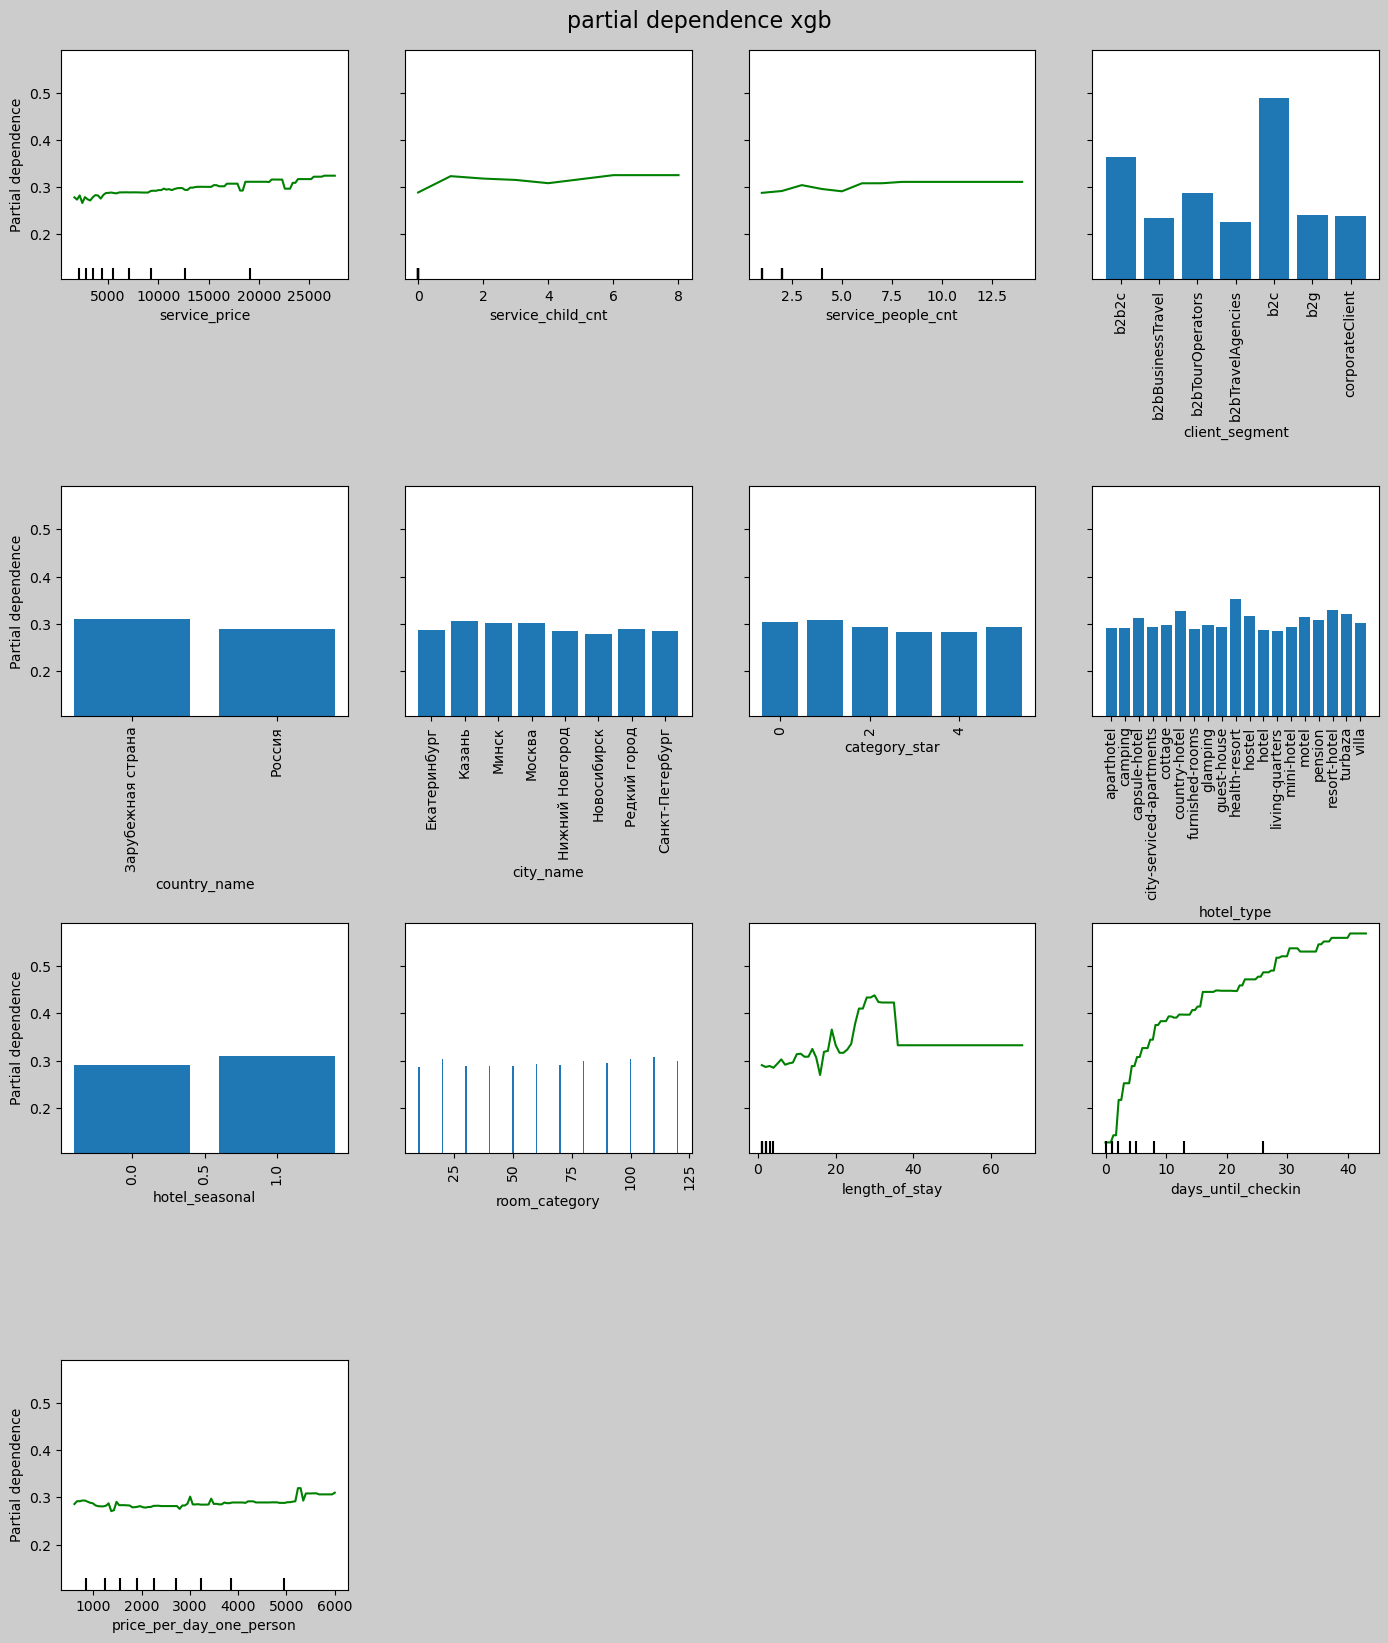

In [100]:
fig, ax = plt.subplots(figsize=(17, 20), facecolor="0.8")

PDD = PartialDependenceDisplay.from_estimator(
    xgb_model_best,
    X_test,
    features=X_test.columns,
    categorical_features=cat_features,
    kind="average",
    n_cols=4,
    random_state=RANDOM_STATE,
    line_kw={"color": "green"},
    ax=ax,
)

fig.subplots_adjust(wspace=0.2, hspace=0.9)
fig.suptitle("partial dependence xgb", fontsize=16, y=0.9);

Для бустинга видим то же, что видели ранее.  
Отдельные клиентские сегменты существенно увеличивают вероятность отмены бронирования (b2b2c, b2c).  
Также видим, что чем заранее клиент оформляет бронирование, тем более вероятно, что он его отменит.

Еще одна интересная зависимость наблюдается с признаком "длительность пребывания".  
До 30-35 дней, c увеличением количества дней пребывания вероятность отмены в среднем увеличивается.  
Далее с увеличением количества дней вероятность отмены постепенно снижается,  
после 40 дней выходит на плато и не изменяется.

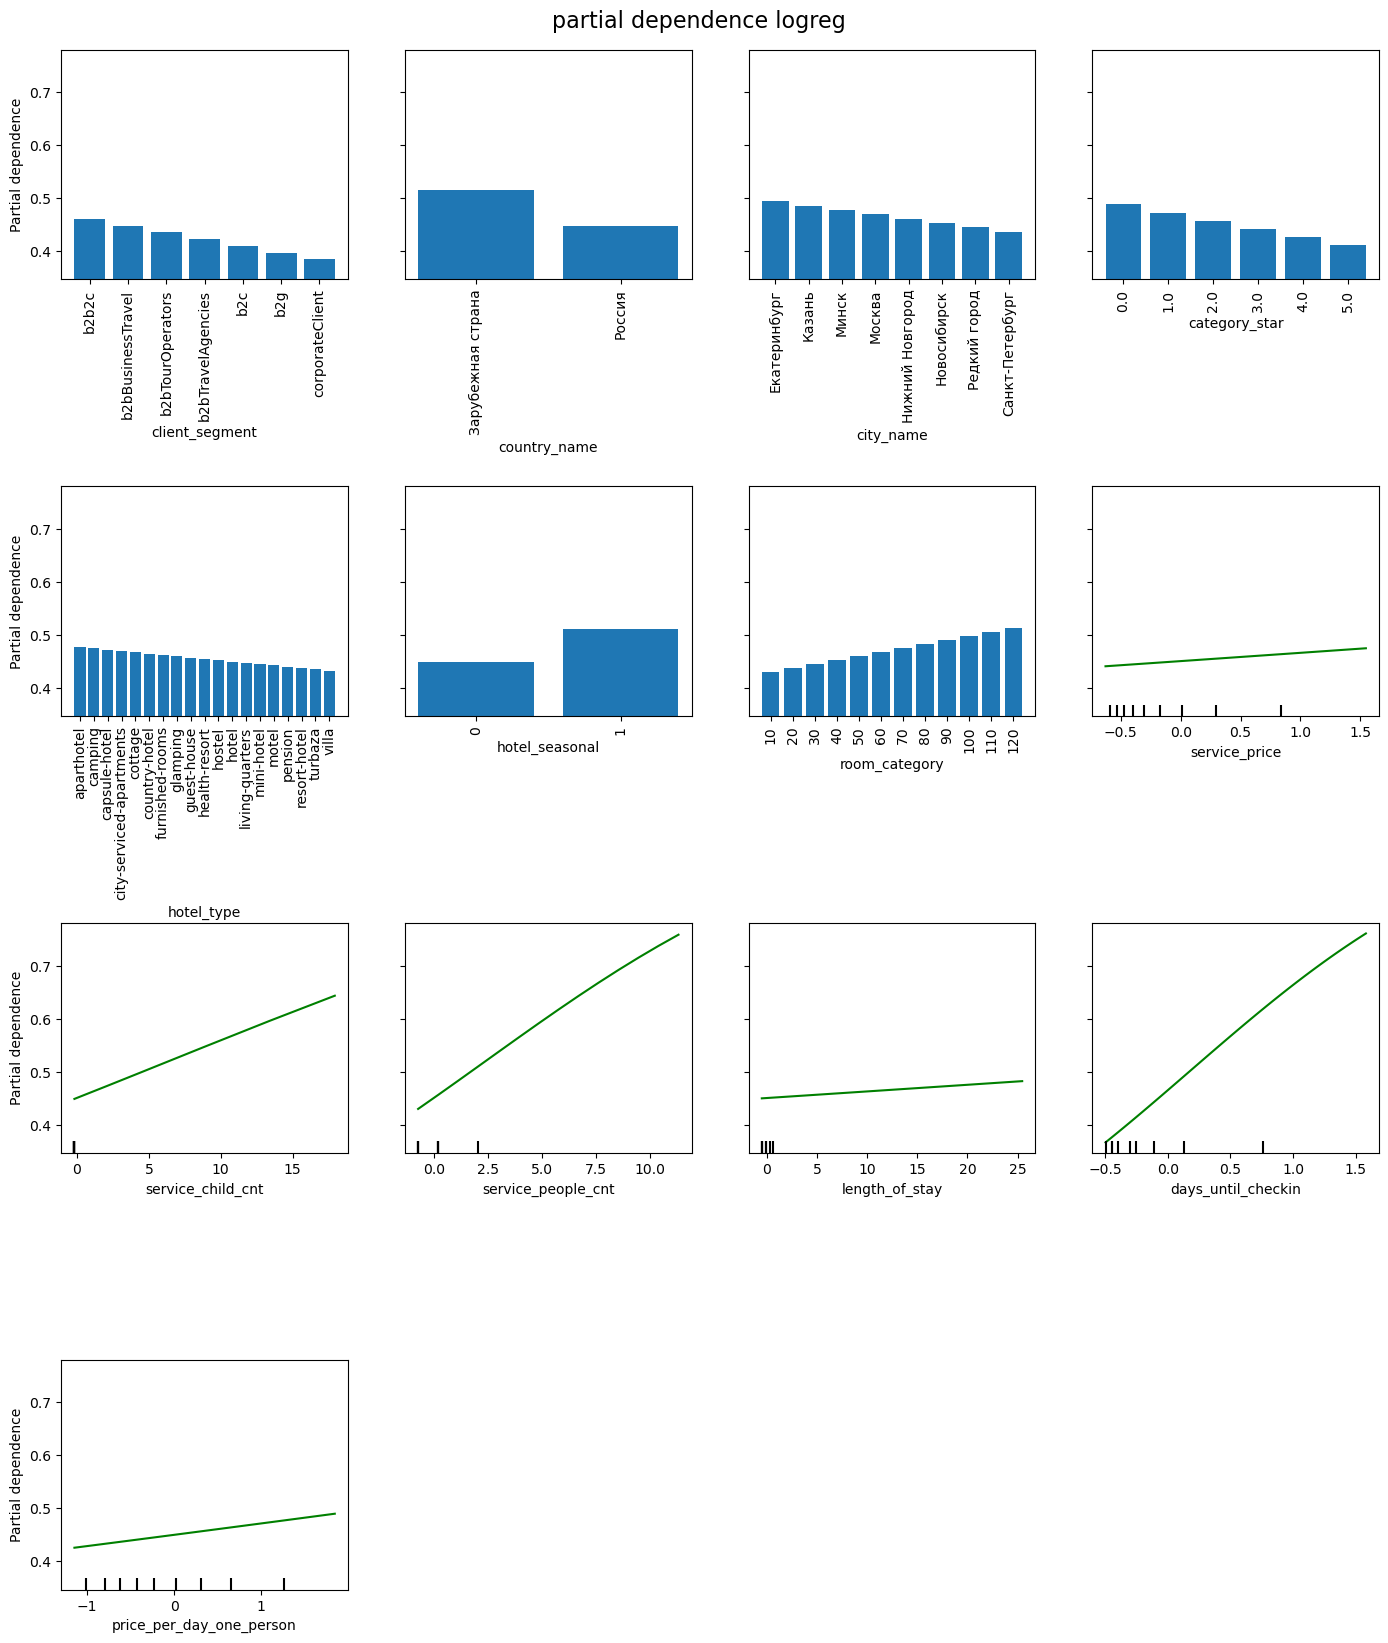

In [101]:
fig, ax = plt.subplots(figsize=(17, 20))

PDD = PartialDependenceDisplay.from_estimator(
    log_reg_model_best,
    X_test_prep_df,
    features=X_test_prep_df.columns,
    categorical_features=cat_features,
    kind="average",
    n_cols=4,
    random_state=RANDOM_STATE,
    line_kw={"color": "green"},
    ax=ax,
)

fig.subplots_adjust(wspace=0.2, hspace=0.9)

original_categories = transformer.transformers_[0][1].categories_

for feature, ax_i in zip(cat_features, PDD.axes_.flatten()):
    if feature in cat_features:
        ticks = list(range(X_test_prep_df[feature].nunique()))
        ax_i.set_xticks(ticks)
        ax_i.set_xticklabels(
            [
                original_categories[cat_features.index(feature)][int(tick)]
                for tick in ticks
                if tick.is_integer()
            ]
        )

fig.suptitle("partial dependence logreg", fontsize=16, y=0.9);

Для логистической регрессии, наиболее крутая зависимость наблюдается от того,  
насколько заранее клиент осуществляет бронирование.  
Также прослеживаются зависимости между количеством детей и человек в целом.

Что касается категориальных признаков, то видно, что для сезонных отелей и зарубежных стран вероятность отмены выше.

## From models

Определим важности признаков на основе обученных моделей.

In [102]:
def feature_importance_plotter(model, features_names):

    feature_importance = model.feature_importances_ / np.sum(model.feature_importances_)

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig = plt.figure(figsize=(8, 4))
    plt.barh(ypos, feature_importance[sorted])
    plt.xlim([0, 1])
    plt.ylabel("Признаки")
    plt.xlabel("Значимость")
    plt.yticks(ypos, features_names[sorted]);

Text(0.5, 1.0, 'feature importances XGBoost')

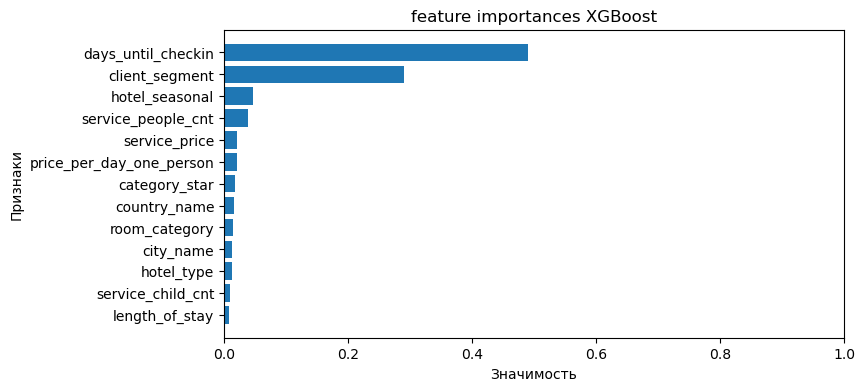

In [103]:
feature_importance_plotter(xgb_model_best, np.array(X_test.columns))
plt.title("feature importances XGBoost")

Важности признаков с точки зрения модели бустинга, в целом, соответствует тому, что было получено на ранних шагах.  
В лидерах - количество дней до заезда. Далее - клиентский сегмент.

In [104]:
def feature_coefficients_plotter(model, features_names):
    coefficients = model.coef_.flatten()

    abs_coefficients = np.abs(coefficients)

    sorted_indices = np.argsort(abs_coefficients)

    ypos = np.arange(len(features_names))

    plt.figure(figsize=(8, 4))
    plt.barh(ypos, abs_coefficients[sorted_indices], color="skyblue")
    plt.xlabel("Абсолютное значение коэффициента")
    plt.ylabel("Признаки")
    plt.yticks(ypos, np.array(features_names)[sorted_indices])
    plt.title("Значимость признаков по коэффициентам Логистической регрессии")
    plt.show()

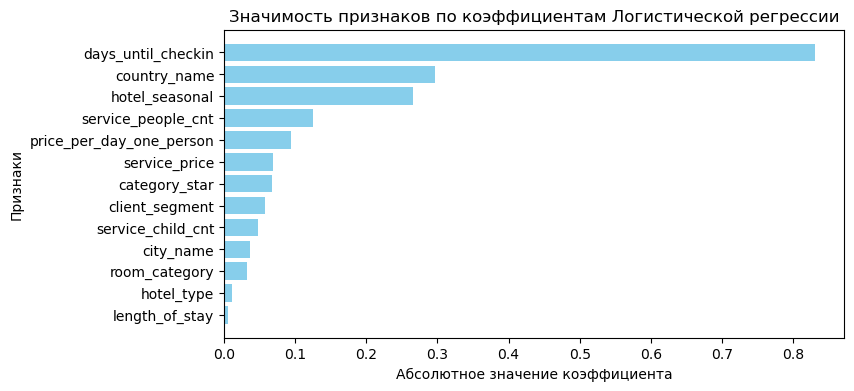

In [105]:
feature_coefficients_plotter(log_reg_model_best, X_test_prep_df.columns)

Для логистической регресии в лидерах так же количество дней до заезда.  
Однако далее идут уже признаки, которые были отмечены при partial dependence - страна и сезонность отеля.  
После идут признаки отмеченные в permutation importance - число человек и цена за 1 человека за сутки.

# Оценка глобальной значимости признаков ***shap***

Рассчитаем значения SHAP

In [107]:
explainer_logreg = shap.Explainer(
    log_reg_model_best, X_test_prep_df, feature_names=X_test_prep_df.columns
)

In [108]:
explainer_tree_xgb = shap.TreeExplainer(xgb_model_best, feature_names=X_test.columns)

In [109]:
shap_values_logreg = explainer_logreg(X_test_prep_df)
shap_values_tree_xgb = explainer_tree_xgb(X_test)

LinearExplainer explainer: 708139it [00:17, 13106.64it/s]                            


Посмотрим на важности признаков на столбчатых диаграммах.

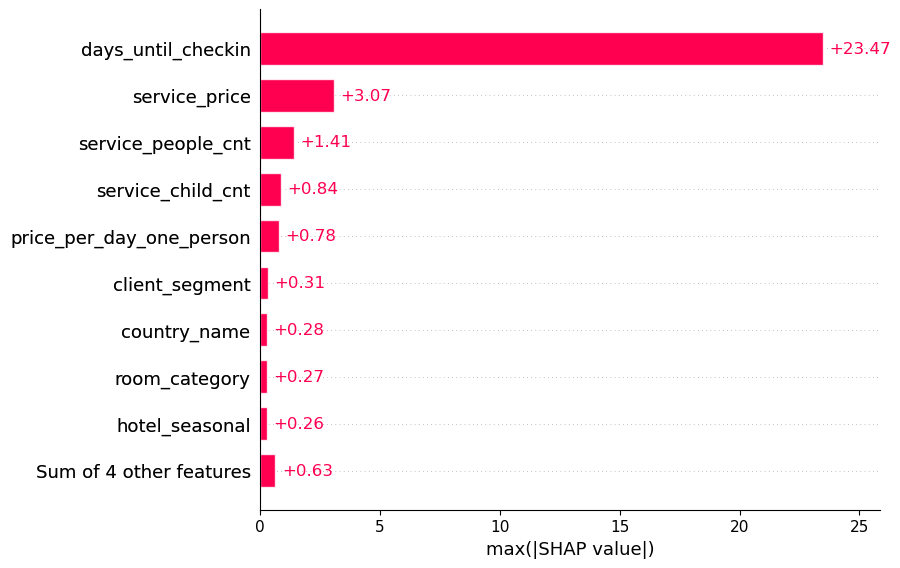

In [137]:
shap.plots.bar(shap_values_logreg.abs.max(0))

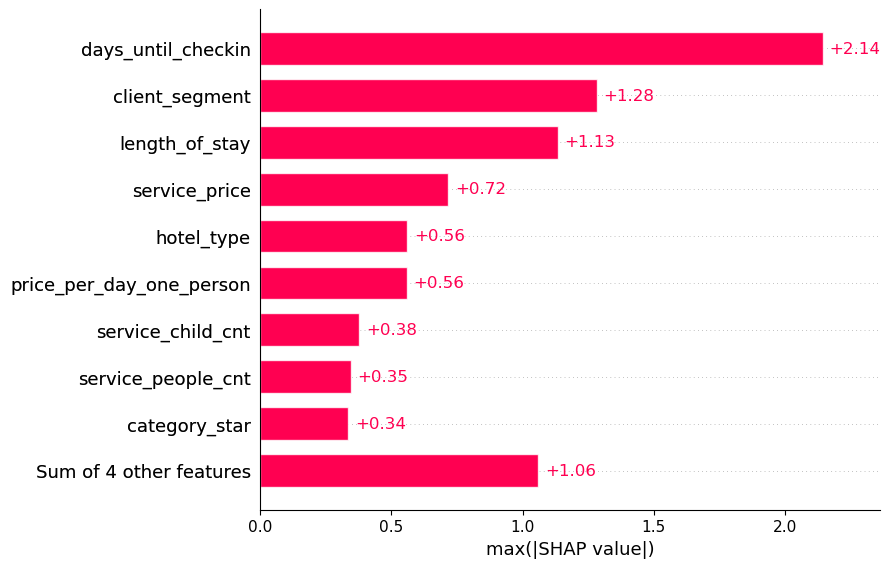

In [138]:
shap.plots.bar(shap_values_tree_xgb.abs.max(0))

Видим, что самый информативный признак "кол-во дней до заезда", здесь так же остается самым важным.  
   
Что касается остальных признаков для бустинга, то здесь их важность оказывается достаточно близка чего не наблюдалось ранее при использовании методов из sklearn, где на втором месте явно доминировал клиентский сегмент.  
  
Для логистической регресии, так же, получаем расхождения.  
Важность признаков более здесь имеет более равномерное распределение.


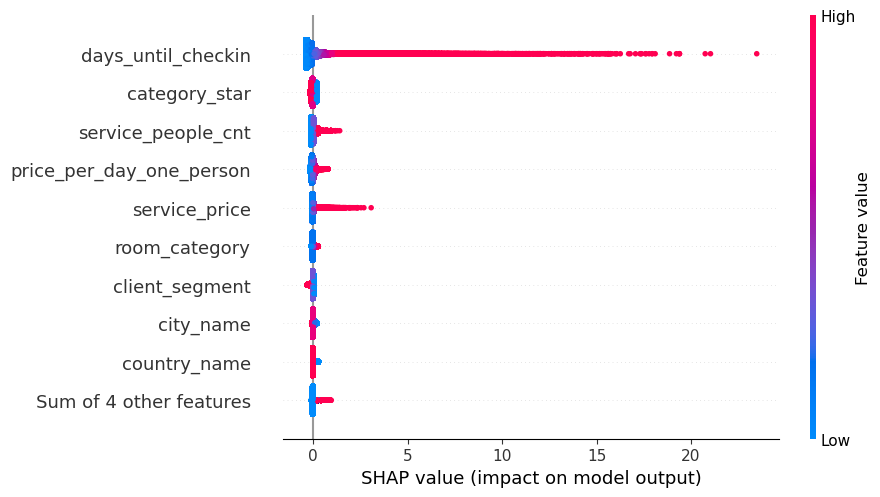

In [139]:
shap.plots.beeswarm(shap_values_logreg)

**Логистическая регрессия**  
Снова наблюдаем важность признака "кол-во дней до заезда", видим что до определенного порога, увеличение дней приводит к увеличению вероятности отнесения объекта к положительному классу.  
После чего прирост количества дней перестает оказывать влияние.  
Так же видим, что чем выше цена и количество персон, то тем выше вероятность отнесения объекта к положительному классу.

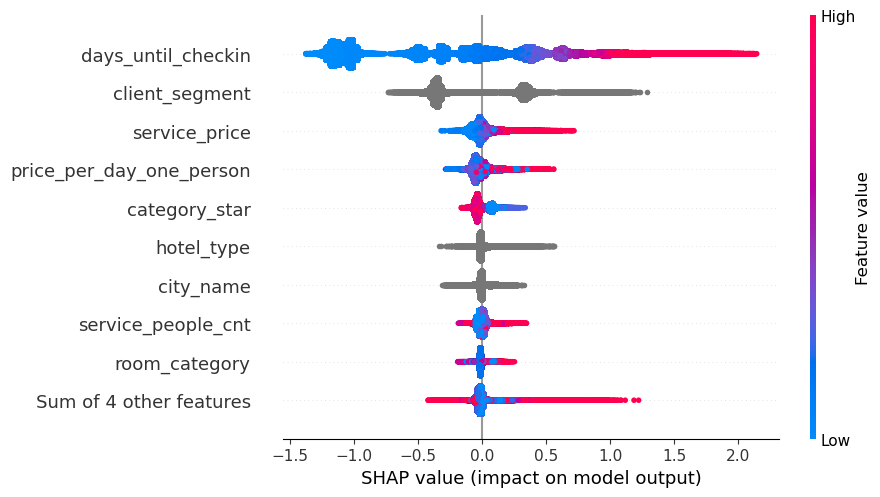

In [140]:
shap.plots.beeswarm(shap_values_tree_xgb)

**Бустинг**  
Так же наблюдаем важность признака "кол-во дней до заезда", но здесь наблюдения уже смещены отностительно нулевого SHAP value, клиенты с относительно "небольшим" значением SHAP могут склонять модель отнести их к положительному классу.  
Заметим, что чем выше количество звезд отеля, тем вероятнее клиент не отменит бронирование.  
Помимо этого, видно что дорогие бронирования вероятнее всего отменят.

# Оценка локальной значимости признаков  ***shap***

**Для корректного отображения графиков необходимо запустить блокнот.**

In [122]:
X_test_prep_df.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [124]:
np.random.seed(seed=RANDOM_STATE)
mistakes_log_reg = np.random.choice(
    X_test_prep_df[y_test != pred_log_reg].index, 10, replace=False
)
mistakes_xgb = np.random.choice(X_test[y_test != pred_xgb].index, 10, replace=False)
success_log_reg = np.random.choice(
    X_test_prep_df[y_test == pred_log_reg].index, 10, replace=False
)
success_xgb = np.random.choice(X_test[y_test == pred_xgb].index, 10, replace=False)

### Ошибки предсказаний логистической регрессии

In [145]:
index = mistakes_log_reg[0]
print(
    f"Предсказанное значение - {pred_log_reg[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 1, фактическое значение - 0


Наблюдаем, что довольно много признаков для данного бронирования свидетельствовало, что клиент должен был его отменить, однако клиент этого не сделал.  
Если бы информация по данному клиенту отсутствовала, то бронирование по умолчанию считалось бы не отмененным.

In [146]:
index = mistakes_log_reg[1]
print(
    f"Предсказанное значение - {pred_log_reg[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 1


Здесь наоборот, признаки говорят о том, что бронирование сохранится (например, количество дней до заезда меньше среднего).  
Но клиент почему-то решил его отменить.  
Здесь решение модели было не сильно уверенным.

In [147]:
index = mistakes_log_reg[2]
print(
    f"Предсказанное значение - {pred_log_reg[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 1


Здесь описание бронирования еще более благоприятное, чтобы сохранить бронирование. Но по факту клиент отменяет.

In [148]:
index = mistakes_log_reg[3]
print(
    f"Предсказанное значение - {pred_log_reg[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 1


Здесь опять спорное решение.  
Большое количество дней до заезда не смогло убедить модель, другие признаки описывали клиента как благоприятного.

In [149]:
index = mistakes_log_reg[4]
print(
    f"Предсказанное значение - {pred_log_reg[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 1, фактическое значение - 0


При данных значениях признаков модель была достаточно уверенна, но ошиблась.

In [180]:
index = mistakes_log_reg[5]
print(
    f"Предсказанное значение - {pred_log_reg[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 1, фактическое значение - 0


Аналогично.

In [181]:
index = mistakes_log_reg[6]
print(
    f"Предсказанное значение - {pred_log_reg[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 1, фактическое значение - 0


Аналогично пунктам выше, уверенность модели с учетом предикторов еще больше.

In [182]:
index = mistakes_log_reg[7]
print(
    f"Предсказанное значение - {pred_log_reg[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 1, фактическое значение - 0


Спорное решение.

In [183]:
index = mistakes_log_reg[8]
print(
    f"Предсказанное значение - {pred_log_reg[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 1, фактическое значение - 0


Так же спорное решение, но признаки склонили модель к положительному классу.

In [184]:
index = mistakes_log_reg[9]
print(
    f"Предсказанное значение - {pred_log_reg[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 1


Решение на грани, признаки "сегмент клиента", "цена за человека за сутки" и "количество дней до заезда" были чуточку убедительнее.

### Ошибки предсказаний бустинга

In [150]:
index = mistakes_xgb[0]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 1, фактическое значение - 0


Здесь наблюдаем base_value = -0.7397 (у регрессии -0.1436), то есть модель бустинга с большей уверенностью отнесет бронивание без описания к нулевому классу.  
Что касается конкретного наблюдения, то 37 дней до заезда и сегмент b2b2c убедили модель в ложном предсказании, но все оказалось иначе.

In [151]:
index = mistakes_xgb[1]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 1


Здесь наоборот, бронивание было совершено не сильно заранее и цена за человека была не так высока, поэтому модель посчитала, что бронирование сохранится.

In [152]:
index = mistakes_xgb[2]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 1


Аналогично.

In [153]:
index = mistakes_xgb[3]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 1, фактическое значение - 0


Большое количество дней пребывания и дней до заезда убедили модель в ложном предсказании.

In [154]:
index = mistakes_xgb[4]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 1, фактическое значение - 0


Здесь роль сыграли клиентский сегмент и дни до заезда.

In [185]:
index = mistakes_xgb[5]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 1


Клиентский сегмент, цена за сутки на человека, и количество проживающих описывали бронивание как "нормальное".

In [186]:
index = mistakes_xgb[6]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 1, фактическое значение - 0


Здесь наоборот, бронирование казалось потерянным.

In [187]:
index = mistakes_xgb[7]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 1


Цена и количество дней до заезда убедить не смогли.

In [188]:
index = mistakes_xgb[8]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 1, фактическое значение - 0


Здесь наоборот, сегмент и дни до заезда ввели в заблуждение.

In [189]:
index = mistakes_xgb[9]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 1


Цена бронивания и сегмент описывали бронирование как сохраняемое.

### Верные предсказания логистической регрессии

In [155]:
index = success_log_reg[0]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 0


Модель была не сильно уверенна в своем предсказании.
Малое количество дней до заезда и число звезд и т.д. подсказали ей верное решение.

In [157]:
index = success_log_reg[1]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 0


Довольно уверенно, благодаря дням до заезда, цене за человека, количеству дней пребывания и суммарной цене.

In [158]:
index = success_log_reg[2]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 0


На грани. По количеству дней до заезда должно было отмениться, но большинство других признаков показывали обратное.

In [159]:
index = success_log_reg[3]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 0


Модель посчитала, что отмены не будет по дням до заезда, числу звезд и количеству проживающих и т.д.

In [160]:
index = success_log_reg[4]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 0


Так же уверенно.

In [190]:
index = success_log_reg[5]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 0


Аналогично.

In [191]:
index = success_log_reg[6]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 0


Аналогично.

In [192]:
index = success_log_reg[7]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 0


На грани, по количеству дней до заезда, звездам, числу проживающих и т.д. модель посчитала, что бронь сохранится.

In [193]:
index = success_log_reg[8]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 0


Более уверенно, существенно повлиял самый полезный признак - количество дней до заезда.

In [194]:
index = success_log_reg[9]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_logreg[index])

Предсказанное значение - 0, фактическое значение - 0


Очень уверенно.

### Верные предсказания предсказаний бустинга

In [161]:
index = success_xgb[0]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 0


Бронирование день в день оказало существенное влияние.

In [163]:
index = success_xgb[1]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 0


Бронирование за день, так же выглядит уверенным.

In [162]:
index = success_xgb[2]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 0


Аналогично.

In [164]:
index = success_xgb[3]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 0


Аналогично.

In [165]:
index = success_xgb[4]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 0


Основную роль сыграло бронирование день в день.

In [195]:
index = success_xgb[5]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 0


Количество дней до бронивания было не столь велико.

In [196]:
index = success_xgb[6]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 0


Бронирование за день и клиентский сегмент.

In [197]:
index = success_xgb[7]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 0


В основном из-за клиентского сегмента.

In [198]:
index = success_xgb[8]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 0


Значение признака кол-во дней до заезда было не столь велико.

In [199]:
index = success_xgb[9]
print(
    f"Предсказанное значение - {pred_xgb[index]}, фактическое значение - {y_test[index]}"
)
shap.plots.force(shap_values_tree_xgb[index])

Предсказанное значение - 0, фактическое значение - 0


Бронирование день в день оказало существенное влияние, чтобы считать бронирование сохраняемым.